In [4]:
# FROM TIRAMISU
# IDEA: Add neck to the posture map?
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import sys, os, pickle
import cv2
from colour import Color
import h5py

import glob


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Check CUDA
print('Cuda:')
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

Cuda:
True
1
GeForce RTX 2080 Ti


# Check the training data is there and declare dataset and loaders

In [6]:
# Make sure the images are in the file

# high-res training data 
top_folder_0 = '/media/chrelli/Data0/recording_20200821-123841'
top_folder_1 = '/media/chrelli/Data1/recording_20200821-123841'
# training data with different exposure
top_folder_0 = '/media/chrelli/Data0/recording_20200828-113642/'
top_folder_1 = '/media/chrelli/Data1/recording_20200828-113642/'

# # training data with implant 
# top_folder_0 = '/media/chrelli/Data0/recording_20201107-092409/'
# top_folder_1 = '/media/chrelli/Data1/recording_20201107-092409/'

# training data with implant with SPIKES
top_folder_0 = '/media/chrelli/Data0/recording_20201108-092537/'
top_folder_1 = '/media/chrelli/Data1/recording_20201108-092537/'

# GOOD SPIKES< female, no laser
top_folder_0 = '/media/chrelli/SSD4TB/Data0_backup/recording_20201110-104449'
top_folder_1 = '/media/chrelli/SSD4TB/Data1_backup/recording_20201110-104449'


training_sets = glob.glob( top_folder_0 + '/*.h5')
skeletons = glob.glob('training_sets' + '/*skeleton_v2*')

print(training_sets)
print(skeletons)

h5_path = training_sets[0]
h5_file = h5py.File(h5_path, 'r')

from c_utils.utils_hour import check_h5_ir
pic = check_h5_ir(h5_path)
plt.figure()
plt.hist(pic.ravel(),50)
plt.show()

[]
['training_sets/skeleton_v2_mice.csv']


IndexError: list index out of range

In [4]:
import imgaug.augmenters as iaa

# snowflakes = iaa.Snowflakes(flake_size = (0.1, 0.4), speed = (0.01, 0.05))




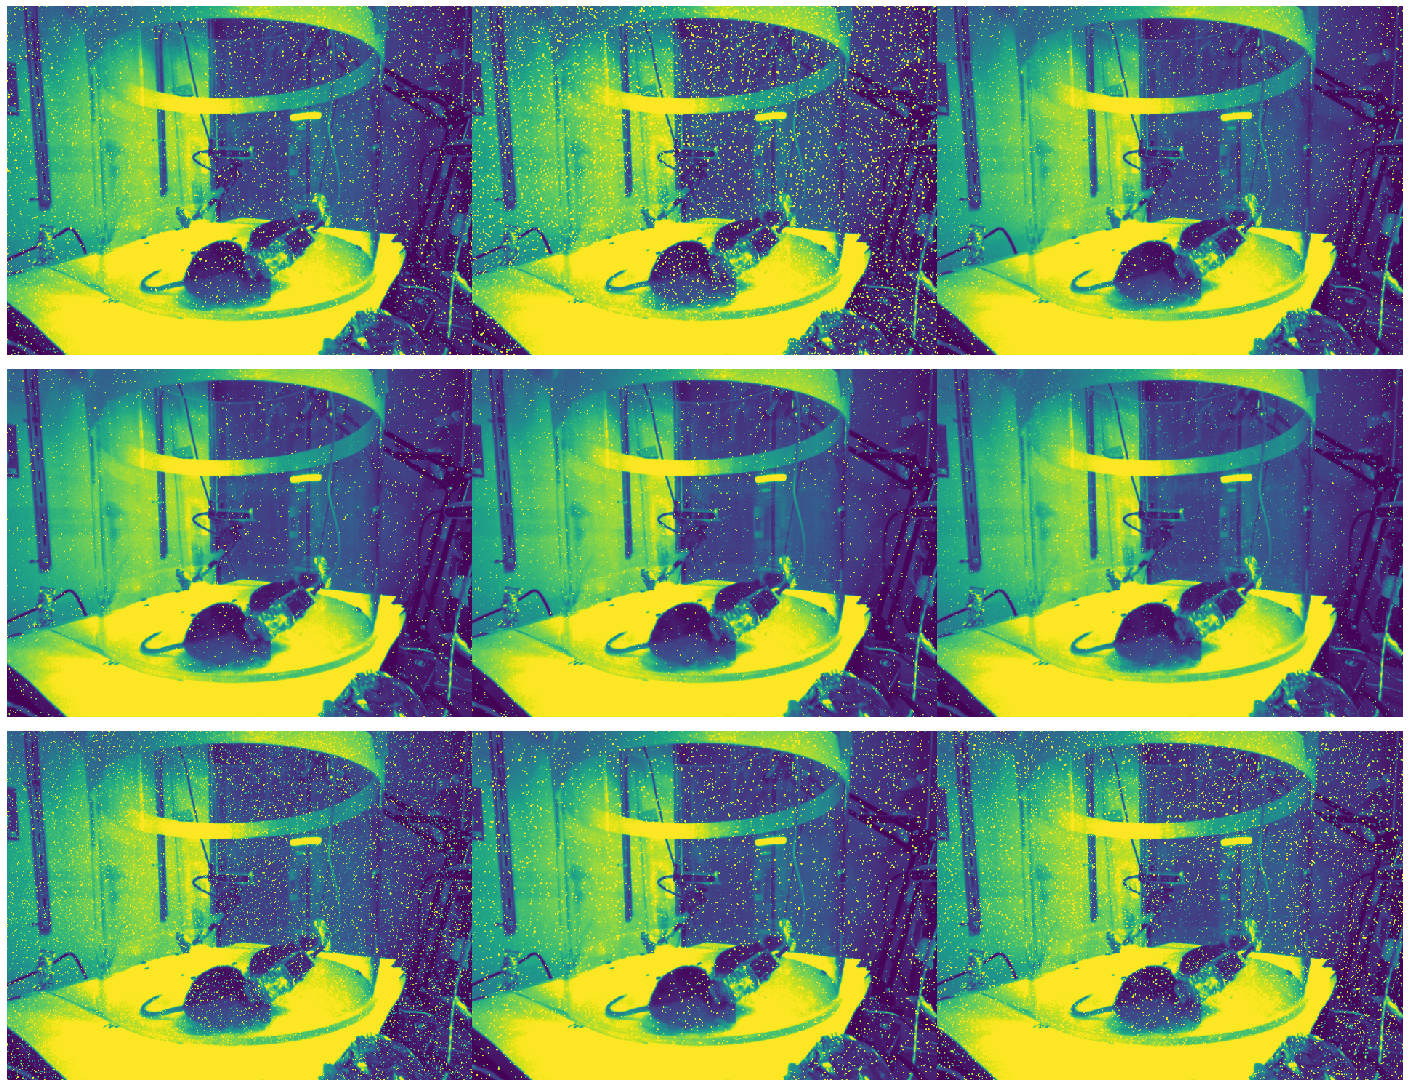

In [5]:
plt.figure(figsize=(25,20))
sqrt_n = 3    
for i in range(sqrt_n**2):
    plt.subplot(sqrt_n,sqrt_n,1+i)
    snowflakes = iaa.Snowflakes(flake_size=(0.1, 0.4), speed=(0.00, 0.00),
                                density = (.01,.1), density_uniformity=(0.99, 1.))
#     snowflakes = iaa.SnowflakesLayer(flake_size=(0.6, 0.8), speed=(0.01, 0.003))
    pic_snow = snowflakes.augment_image(pic)
    plt.imshow(pic_snow)

    plt.axis('off')
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()



In [6]:
if False:
    # size is 720 x 1280, let's try to make it 512 x 1024
    pad_right = 1280-1024
    pad_top = int( (720 - 512) / 2 )
    pad_bottom = 720 - 512 - pad_top

    plt.imshow(pic_snow[pad_top:-pad_bottom,:-pad_right])


(448, 640)


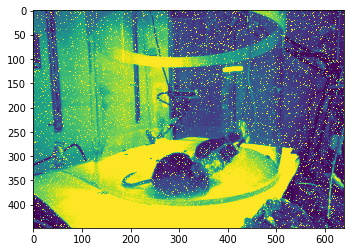

In [7]:
if True:
    # size is 480 x 640, let's try to make it 448 x 640
    pad_right = 0
    pad_top = 480-448 - 2
    pad_bottom = 2

    print(pic_snow[pad_top:-pad_bottom,:].shape)
    plt.imshow(pic_snow[pad_top:-pad_bottom,:])

In [8]:
# the images have to be repeatedly divisible with two, so these are the options
exp = np.arange(1,12)
exp = 2**exp
print(1*exp);print(3*exp);print(5*exp);print(7*exp);print(11*exp)

[   2    4    8   16   32   64  128  256  512 1024 2048]
[   6   12   24   48   96  192  384  768 1536 3072 6144]
[   10    20    40    80   160   320   640  1280  2560  5120 10240]
[   14    28    56   112   224   448   896  1792  3584  7168 14336]
[   22    44    88   176   352   704  1408  2816  5632 11264 22528]


In [9]:
# make a minimal dataset to loop over the frames!!
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
import torch
import torch.utils.data as data
import imgaug.augmenters as iaa

from c_utils.utils_hour import gaussian

# HACK for imgaug for now, numpy had a code change in 1.8
# import numpy
# numpy.random.bit_generator = numpy.random._bit_generator


selfseq = iaa.Sequential([
        #     iaa.Crop(px=(0, 100)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.CropAndPad(percent=(-0.10, 0.15), sample_independently=False),
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.Sometimes(.3, iaa.GaussianBlur(sigma=(0, 1.5)) ), # blur images with a sigma of 0 to 3.0
            iaa.Sometimes( 1, iaa.Dropout(p = (0,0.2)) ),
            # added some exposure variation as well!
            iaa.Affine(rotate=(-30, 30),
                       translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
        ],random_order=True)
   
snowflakes = iaa.Snowflakes(flake_size=(0.5, 0.7), speed=(0.001, 0.003), density_uniformity=(0.99, 1.))
# pic_snow = snowflakes.augment_image(pic)

class MouseDataset(data.Dataset):
    # todo add augmentation here, clean up and make faster
    # todo remove stupid side effects etc
    def __init__(self, h5_data,which_indices,augmentation=False):
        '''Initialization'''
        self.label_names = ['impl','ear','ear','nose','tail','ear','ear','nose','tail']
        self.label_index = [0,1,1,1,1,2,2,3,3]
        
        # index for loading subsets from the h5 file
        self.which_indices = which_indices       
        self.n_images = len(which_indices)
    

        # FOR THE AUGMENTATION PIPELINE

        self.seq = iaa.Sequential([
#             iaa.Multiply((0.5, 1.5)), # multiply the brightness
#             iaa.Add((-30, 30)), # add to the brightness
        #     iaa.Crop(px=(0, 100)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.CropAndPad(percent=(-0.10, 0.15), sample_independently=False),
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.Sometimes(.3, iaa.GaussianBlur(sigma=(0, 1.5)) ), # blur images with a sigma of 0 to 3.0
            iaa.Sometimes( 1, iaa.Dropout(p = (0,0.2)) ),
            iaa.Affine(rotate=(-30, 30),
                       translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
        ],random_order=False)
        
        self.augmentataion = augmentation
       
    def __len__(self):
        'Denotes the total number of samples'
        return self.n_images    
        
    def __getitem__(self, index):
        # will be i x j x 1 - is that ok?
        # todo check if this moveaxis is good?
        # im = np.moveaxis(h5_data['c_images'][self.which_indices[index]],[0,1],[1,2])
#         tracking_folder = '/home/chrelli/Documents/Example3D_compressed'
#         h5_path = tracking_folder + '/mouse_rgbd_annotation_set.h5'
#         h5_path = 'training_sets/mouse_training_set_labeled.h5'
        with h5py.File(h5_path, 'r') as h5_file:
            xy = h5_file['annotations'][self.which_indices[index]]
            c_image = h5_file['c_images'][self.which_indices[index]]
            # dac_image = h5_file['dac_images'][self.which_indices[index]]
        
       
        # check if the points are good before augmentation
        # upper left corner is trash
        point_good = (xy[:,0] > 30)*( xy[:,1] > 30)
        
        # NOW, AUGMENT!
        # TODO AUGMENT DEPTH AS WELL?
        # AUGMENT DEPTH BY DEAD BLOCKS TO SIMULATE REAL DATA?
        
        high_res = True        

        if self.augmentataion and not high_res:
            #HACK: selfseq instead of self.seq
            images_aug, xy_aug_list = self.seq(images = c_image[np.newaxis,:,:,:], keypoints=[xy])
            xy = xy_aug_list[0]
            c_image = images_aug[0,:,:,:]
            
        if self.augmentataion and high_res:
            #HACK: selfseq instead of self.seq
            images_aug, xy_aug_list = self.seq(images = c_image[np.newaxis,:,:], keypoints=[xy])
            xy = xy_aug_list[0]
            c_image = images_aug[0,:,:]
            
            
        snowflakes = iaa.Snowflakes(flake_size=(0.1, 0.4), speed=(0.00, 0.00),
                                density = (.001,.1), density_uniformity=(0.99, 1.))
        add_snow = True 
        if add_snow:
            c_image = snowflakes.augment_image(c_image)            
            
        # pack depth and pixels to target - OR NOT??
        im = c_image
        frame_height = im.shape[0]
        frame_width = im.shape[1]
        
        if high_res:
            # size is 
            pad_right = 0
            pad_top = 480-448 - 2
            pad_bottom = 2

            
            im = im[pad_top:-pad_bottom,:]
            # and make the image Chan X heigh X width
            im = im[np.newaxis,:,:]
        else:
            # make the resolution correct, i.e. set the height to 192
            pad_top = 8
            pad_bottom = 10
            
            im = im[pad_top:-pad_bottom,:,:]
        
            # and make the image Chan X heigh X width
            im = np.moveaxis(im,2,0)
        
        # recale the keypoints
        xy[:,1] -= pad_top
            
        rescale = True
        h_out,w_out = im.shape[1],im.shape[2]
        label_sigma = np.array([2,1,1,1,1,1,1,1,1]) *1.5 *2
        gaussian_sigma = (15,15)
        line_thickness = 3
        
        if rescale:
            # halved
            h_out,w_out = int(h_out/4),int(w_out/4)
            xy = np.round(xy/4).astype('int')
            if high_res:
                label_sigma = np.array([2,1,1,1,1,1,1,1,1]) 
                gaussian_sigma = (3,3)
                line_thickness = 2
            else:
                label_sigma = np.array([2,1,1,1,1,1,1,1,1]) 
                gaussian_sigma = (3,3)
                line_thickness = 1

        label_names = ['impl','ear','ear','nose','tail','ear','ear','nose','tail']
        body_names = ['mouse0','mouse0','mouse0','mouse0','mouse0','mouse1','mouse1','mouse1','mouse1']
        label_index = [0,1,1,2,3,1,1,2,3]
        body_index = [0,0,0,0,0,1,1,1,1]

        # target has to be batch x n_features x pic_i x pic_j
        target_points = np.zeros((4,h_out,w_out))
        img = target_points[0,:,:].copy()

        for i in range(9):
            if point_good[i]:
                target_points[label_index[i],:,:] += ( gaussian(img.copy(), xy[i,:], label_sigma[i]) )        

        # draw the lines within the body!
        xy_good = xy[point_good]
        label_good = xy[point_good]
        body_good = xy[point_good]


        target_lines = []

        def draw_lines(p1,p2):
            img_blank = np.zeros((h_out,w_out)).astype('uint8')
            for i1,i2 in zip(p1,p2):
                if point_good[i1]*point_good[i2]:
                    start = tuple(np.round(xy[i1,:]).astype('int') )
                    end = tuple(np.round(xy[i2,:]).astype('int') )
                    cv2.line(img_blank,start,end,[255,255,255],thickness = line_thickness)
                img_blank = np.clip(img_blank,0,255)
                img_blank = cv2.GaussianBlur(img_blank,gaussian_sigma,0)
            img_blank = img_blank/255
            target_lines.append(img_blank.copy())            
            
        # I to ears
        p1,p2 = [0,0],[1,2]
        draw_lines(p1,p2)

        # I to nose
        p1,p2 = [0],[3]
        draw_lines(p1,p2)

        # I to tail
        p1,p2 = [0],[4]
        draw_lines(p1,p2)

        # Ear to Ear
        p1,p2 = [1,5],[2,6]
        draw_lines(p1,p2)

        # Ear to Tail
        p1,p2 = [1,2,5,6],[4,4,8,8]
        draw_lines(p1,p2)

        # Ear to Nose
        p1,p2 = [1,2,5,6],[3,3,7,7]
        draw_lines(p1,p2)

        # Nose to Tail
        p1,p2 = [3,7],[4,8]
        draw_lines(p1,p2)

        # stack all the targets
        target_lines = np.concatenate([t[np.newaxis,:,:] for t in target_lines],axis=0)
        target = np.concatenate((target_points,target_lines),axis = 0)
        
        # convert to sensible ranges
        im = im / 255.
        
        im = np.clip(im,0,1)
        
        # from documentation    
        # For a conv2D, input should be in (N, C, H, W) format. N is the number of samples/batch_size. C is the channels. H and W are height and width resp.
        # See shape documentation at https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d    
        # so im is (batch, channels, H, W) 
        # target is (n_trained_features, H, W) 
        
        return im.astype('float32'),target.astype('float32')

# # separate by pseudo-random indices
np.random.seed(0)

with h5py.File(h5_path, 'r') as h5_file:
    n_frames = h5_file['c_images'].shape[0]
    print("n_frames = " +str(n_frames) )
# n_frames = 576
random_indices = np.random.permutation(n_frames)

MouseTrain = MouseDataset(h5_file,random_indices[:],augmentation=True)
MouseValid = MouseDataset(h5_file,random_indices[:50])

# we shuffle, so that we always see different dumps
# MouseTrainLoader = data.DataLoader(MouseTrain, batch_size=1, shuffle=True, num_workers = 1)
MouseTrainLoader = data.DataLoader(MouseTrain, batch_size=1, shuffle=True)
MouseValidLoader = data.DataLoader(MouseValid, batch_size=1, shuffle=True, num_workers = 1)

print("training augment = {}".format(MouseTrain.augmentataion) )
print("validation augment = {}".format(MouseValid.augmentataion) )


n_frames = 720
training augment = True
validation augment = False


In [10]:
self = MouseTrain
index = 10
print(h5_path)
# h5_path = 'training_sets/mouse_training_set_labeled.h5'
with h5py.File(h5_path, 'r') as h5_file:
    xy = h5_file['annotations'][self.which_indices[index]]
    c_image = h5_file['c_images'][self.which_indices[index]]
    # dac_image = h5_file['dac_images'][self.which_indices[index]]



/media/chrelli/Data0/recording_20201110-104449/mouse_training_set.h5


torch.Size([1, 1, 448, 640])
torch.float32
tensor(1.)


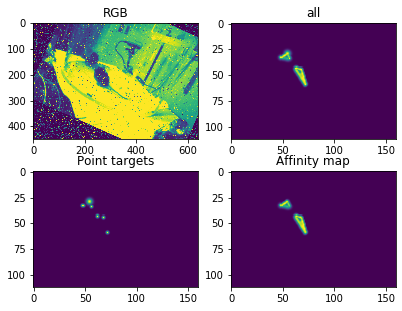

torch.Size([1, 1, 448, 640])
torch.float32
tensor(1.)


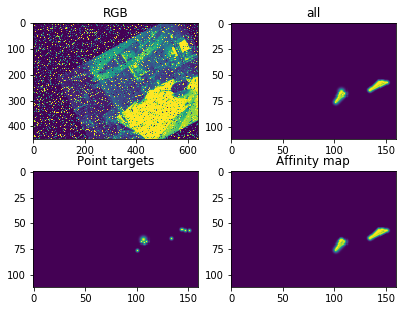

torch.Size([1, 1, 448, 640])
torch.float32
tensor(1.)


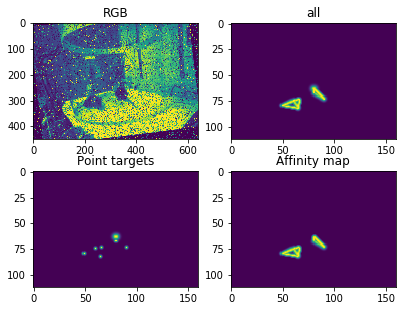

In [11]:
# check that some randoms are fine and augmented
from c_utils.utils_hour import plot_im_target,plot_im_target_ir, random_from
for i in range(3):    
#     im,target = random_from( MouseTrainLoader)
    im,target = next(iter( MouseTrainLoader))
    print(im.shape)
    print(im.dtype)
    print(torch.max(im))

    plot_im_target_ir(im,target,5)    

15
torch.Size([1, 1, 448, 640])


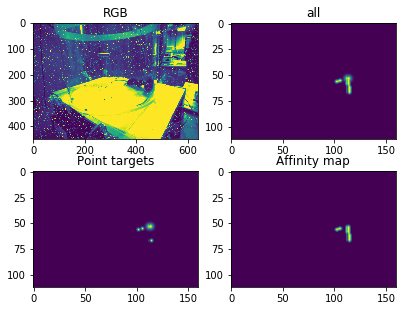

37
torch.Size([1, 1, 448, 640])


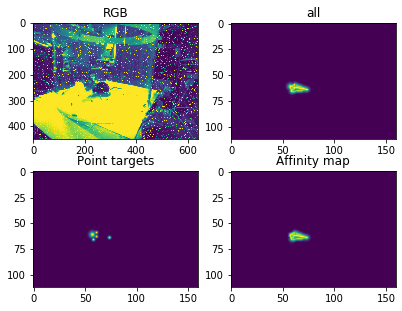

In [12]:
# check that some randoms from the valid are not augmented
from c_utils.utils_hour import plot_im_target, random_from
for _ in range(2):    
    im,target = random_from( MouseValidLoader)
#     im,target = next(iter( MouseTrainLoader))
    print(im.shape)
    plot_im_target_ir(im,target,5)      


1


/home/chrelli/git/3ddd_mouse_tracker/analysis/c_utils/utils_hour.py:371: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,2)


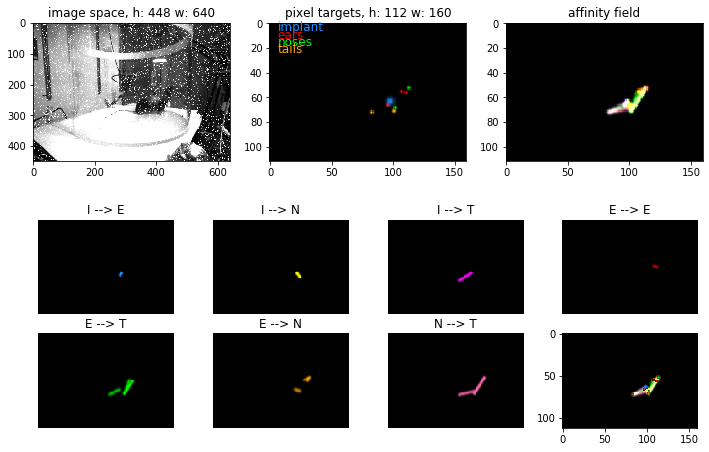

In [13]:
# save an example for a figure!
from c_utils.utils_hour import plot_im_target_pseudo,plot_im_target_pseudo_ir,random_from

from c_utils.utils_hour import plot_im_target_pseudo,specific_from,plot_im_target_pseudo_ir,plot_and_dump_im_target_pseudo
# 1 is good
im,target = specific_from(MouseValidLoader,1)
plot_im_target_pseudo_ir(im,target,8)



37
torch.Size([1, 1, 448, 640])


/home/chrelli/git/3ddd_mouse_tracker/analysis/c_utils/utils_hour.py:380: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow( color_im/np.max(color_im) )


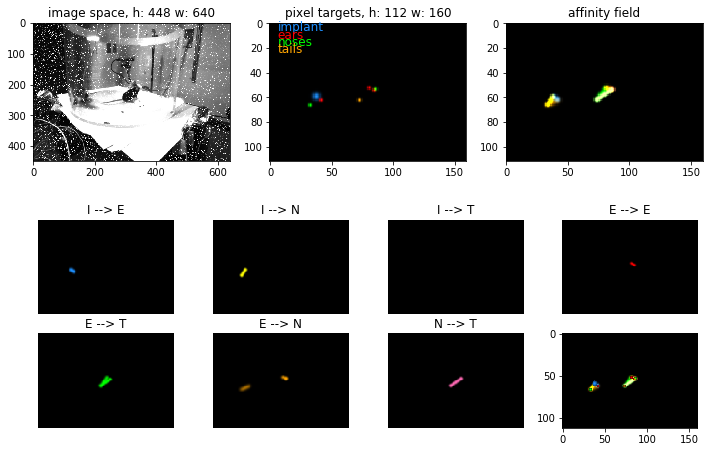

49
torch.Size([1, 1, 448, 640])


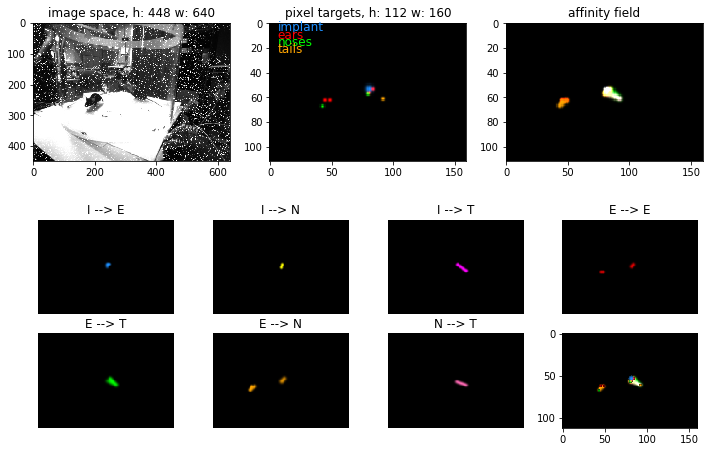

31
torch.Size([1, 1, 448, 640])


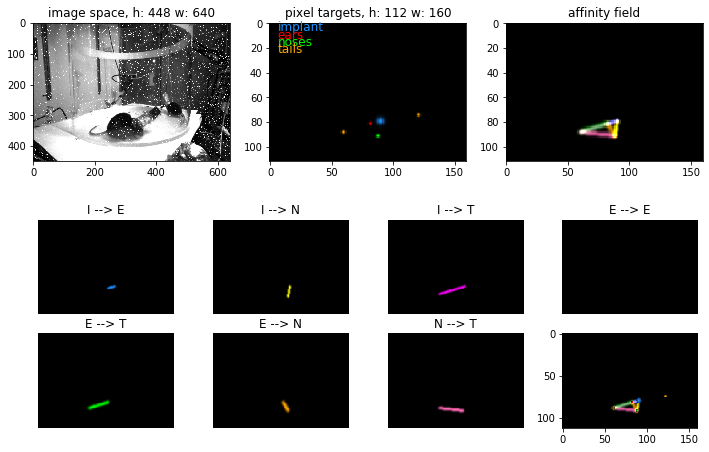

In [14]:
# Look at a few examples with merged fields
from c_utils.utils_hour import plot_im_target_pseudo,plot_im_target_pseudo_ir,random_from
for _ in range(3):
    im,target = random_from(MouseValidLoader)
    print(im.shape)
    plot_im_target_pseudo_ir(im,target,8)

# SET up for learning

## Make the hourglass net

In [15]:
# OK, we now have a generator, let's print from it
print("Train: %d" %len(MouseTrainLoader))
print("Val: %d" %len(MouseValidLoader))
inputs, targets = next(iter(MouseTrainLoader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())
print("Channels: %d" %inputs.shape[1] )
print("Classes: %d" %target.shape[1] )

    
# import the hourglass model and set up architecture
from architectures.hourglass import hg
global best_acc

N_STACKS = 3

model = hg(
    num_stacks=N_STACKS,
    num_blocks=1,
    num_channels=1,    
    num_classes=11,
    num_feats=128,
    inplanes=64,
    init_stride=2,
)
    
model = torch.nn.DataParallel(model).cuda()
# set the loss
criterion = torch.nn.MSELoss(size_average=True).cuda()


Train: 720
Val: 50
Inputs:  torch.Size([1, 1, 448, 640])
Targets:  torch.Size([1, 11, 112, 160])
Channels: 1
Classes: 11


/home/chrelli/anaconda2/envs/mousepose/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Set the optimizer, LR schedule and the hourglass loss

In [16]:
# MAKE optimizer
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr= 0.00025,
    momentum=0,
    weight_decay=0,
)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)


# custom loss function for weighing
def weighted_mse_loss(input, target, weights):
    out = (input - target) ** 2
    out = out * weights.expand_as(out)
    loss = out.sum()
    return loss

# also load a summary_writer for tensorboard
def weighted_hourglass_loss(inputs,targets,output):
    # loss_weight = torch.ones((inputs.size(0), args.num_classes, 1, 1))
    loss_weight = torch.ones((inputs.size(0), targets.size(1), 1, 1))
    
    loss_weight.requires_grad = True
    loss_weight = loss_weight.cuda()

    # add all the loss maps together (8 hourglasses)
    loss = weighted_mse_loss(output[0], targets, weights=loss_weight)
    for j in range(1, len(output)):
        loss += weighted_mse_loss(output[j], targets, weights=loss_weight)

    return loss


# also load a summary_writer for tensorboard
def weighted_hourglass_loss_noPAF(inputs,targets,output):
    targets = targets[:,:4,:,:]
    output = [o[:,:4,:,:] for o in output]
    
    # loss_weight = torch.ones((inputs.size(0), args.num_classes, 1, 1))
    loss_weight = torch.ones((inputs.size(0), targets.size(1), 1, 1))
    
    loss_weight.requires_grad = True
    loss_weight = loss_weight.cuda()

    # add all the loss maps together (8 hourglasses)
    loss = weighted_mse_loss(output[0], targets, weights=loss_weight)
    for j in range(1, len(output)):
        loss += weighted_mse_loss(output[j], targets, weights=loss_weight)

    return loss

## Define a training step

In [17]:
# make a function which will do a training step!
from torch.autograd import Variable
epoch = 0
def train(model, trn_loader, optimizer, epoch, noPAF = False):
    model.train()
    epoch_loss = 0
    frame_loss = []
    NN = trn_loader.__len__()
    
    # trn_error = 0
    for idx, data in enumerate(trn_loader):
            
        ### output some progress ###
        if idx%10 == 0:
            print("im {} of {}...".format(idx,NN))
            
        ### PREPARE TENSORS ###
        
        # make right byte and shape (# remove the depth dimension)
        if data[0].shape[1] > 3:
            inputs = data[0][:,:3,:,:].float()
        else:
            inputs = data[0].float()
        targets = data[1].float()
               
        # send to cuda
        inputs = Variable(inputs.cuda())
        targets = Variable(targets.cuda(non_blocking=True))

        ### CALC LOSS ###
        
        # compute model output
        output = model(inputs)
        # get the score map to the cpu?  not now
        # score_map = output[-1].data.cpu()       
        
        # calculate the loss weights and send to cuda
        # it's a one pr class - maybe scale for the affinity fields?
        # scale by input weight, for example?
        # should call it class weight?
        if noPAF:
            loss = weighted_hourglass_loss_noPAF(inputs,targets,output)
        else:
            loss = weighted_hourglass_loss(inputs,targets,output)
        
        ### DO BACKPROP ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        frame_loss.append(loss.item())
        
    epoch_loss /= len(trn_loader)
    # trn_error /= len(trn_loader)
    return epoch_loss, frame_loss #, trn_error

# epoch_loss, frame_loss = train(model, TestTrainLoader, optimizer, epoch)
# frame_loss

## Define a validation step

In [18]:
# make a function which will do a training step!
from torch.autograd import Variable

def test(model, trn_loader, optimizer, epoch, noPAF=False):
    model.eval()
    epoch_loss = 0
    frame_loss = []
    
    # trn_error = 0
    for idx, data in enumerate(trn_loader):
                
        ### PREPARE TENSORS ###
        
        # make right byte and shape (# remove the depth dimension)
        if data[0].shape[1] > 3:
            inputs = data[0][:,:3,:,:].float()
        else:
            inputs = data[0].float()
        targets = data[1].float()
               
        # send to cuda
        inputs = Variable(inputs.cuda())
        targets = Variable(targets.cuda(non_blocking=True))

        ### CALC LOSS W/O GRAD ###
        
        with torch.no_grad():
            # compute model output
            output = model(inputs)      
            if noPAF:
                loss = weighted_hourglass_loss_noPAF(inputs,targets,output)
            else:
                loss = weighted_hourglass_loss(inputs,targets,output)
        
        epoch_loss += loss.item()
        frame_loss.append(loss.item())
        
    epoch_loss /= len(trn_loader)
    # trn_error /= len(trn_loader)
    return epoch_loss, frame_loss #, trn_error

# epoch_loss, frame_loss = test(model, TestTrainLoader, optimizer, epoch)
# frame_loss

## Define a saving func (dump weights) and a plotting func (dump figure)

In [19]:
# A HELPER FUNCTION WHICH SAVES THE STATE OF THE NETWORK, maybe every 10 epochs or smth?
import os
import sys
import math
import string
import random
import shutil

WEIGHTS_PATH = '192x320_weights/'
WEIGHTS_PATH = '/media/chrelli/SSD4TB/revision_profiling/3500ms_implanted_{}_STACKS_NOPAF/'.format(N_STACKS)

def save_weights(model, epoch, loss):
    time_string = time.strftime('%Y-%m-%d_%H-%M-%S',time.localtime())
    weights_fname = 'singlecore_weights_epoch_%d_loss_%.3f_'% (epoch, loss) +time_string+'.pth' 
    weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)
    torch.save(model.state_dict(), weights_fpath)
    shutil.copyfile(weights_fpath, WEIGHTS_PATH+'singlecore_latest.th')

# Make sure that the path is here    
if not os.path.exists(WEIGHTS_PATH):
    os.makedirs(WEIGHTS_PATH)

In [20]:
from c_utils.utils_hour import plot_ito_pseudo,plot_ito_pseudo_ir

def dump_inspection(model, trn_loader, optimizer, epoch,WEIGHTS_PATH,filetag=''):
    # def dump_inspection(model, trn_loader, epoch, EIGHTS_PATH):
    model.eval()
    epoch_loss = 0
    frame_loss = []

    idx, data = next(iter(enumerate( trn_loader)))

    ### PREPARE TENSORS ###

    # make right byte and shape (# remove the depth dimension)
    if data[0].shape[1] > 3:
        inputs = data[0][:,:3,:,:].float()
    else:
        inputs = data[0].float()
    targets = data[1].float()

    # send to cuda
    inputs = Variable(inputs.cuda())
    targets = Variable(targets.cuda(non_blocking=True))

    ### CALC LOSS W/O GRAD ###
    with torch.no_grad():
        # compute model output
        output = model(inputs)        
        loss = weighted_hourglass_loss(inputs,targets,output)

    Fig1 = plot_ito_pseudo_ir(inputs,targets,output,size = 10)

    time_string = time.strftime('%Y-%m-%d_%H-%M-%S',time.localtime())
    fig_fname = 'singlecore_'+filetag+'_'+time_string+'_epoch_%d_loss_%.3f_'% (epoch, loss) +'.png' 
    fig_fpath = os.path.join(WEIGHTS_PATH, fig_fname)

    plt.savefig(fig_fpath)
    plt.close(Fig1)    
    
# dump_inspection(model, trn_loader, optimizer, epoch,WEIGHTS_PATH)

# TRAINING LOOP

In [21]:
# run actual training loop

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

train_loader = MouseTrainLoader
val_loader = MouseValidLoader

N_EPOCHS = 120
START_EPOCH = 0

for epoch in range(START_EPOCH, START_EPOCH+N_EPOCHS):
    since = time.time()

    ### Train ###
    trn_loss, trn_frame_loss = train(model, train_loader, optimizer, epoch, noPAF = False)
    print('Epoch {:d}\nTrain - Loss: {:.4f}'.format(epoch, trn_loss))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format( time_elapsed // 60, time_elapsed % 60) )
    
    ### Test ###    
    val_loss, val_frame_loss = test(model, val_loader, optimizer, epoch, noPAF = False)
    print('Epoch {:d}\nValidation - Loss: {:.4f}'.format(epoch, val_loss))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format( time_elapsed // 60, time_elapsed % 60) )
    
   
    ### Checkpoint ###  
    if epoch % 10 == 0:
        save_weights(model, epoch, val_loss)

    ### write to and save a figure ###
        
    writer.add_scalar('trn_loss', trn_loss, global_step=epoch)
    writer.add_scalar('val_loss', val_loss, global_step=epoch)
            
    for jjii,ll in enumerate(trn_frame_loss):
        writer.add_scalar('trn_frame_loss', ll,global_step=len(trn_frame_loss)*epoch+jjii)

    for jjii,ll in enumerate(val_frame_loss):
        writer.add_scalar('val_frame_loss', ll,global_step=len(val_frame_loss)*epoch+jjii)

    for param_group in optimizer.param_groups:
        lr_now = param_group['lr']        
    writer.add_scalar('lr', lr_now, global_step=epoch)
    # also savethis
    writer.add_scalar('n_train', len(trn_frame_loss), global_step=epoch)
    writer.add_scalar('n_val', len(val_frame_loss), global_step=epoch)
    writer.add_scalar('n_stakcs', N_STACKS, global_step=epoch)
    
    dump_inspection(model, train_loader, optimizer, epoch,WEIGHTS_PATH,filetag='train')
    dump_inspection(model, val_loader, optimizer, epoch,WEIGHTS_PATH,filetag='valid')
    
    ### Adjust learning rate ###
    scheduler.step(val_loss)
    
#     if epoch == 90:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = 1e-4
    
save_weights(model, epoch, val_loss)    
writer.close()


im 0 of 720...
im 10 of 720...
im 20 of 720...
im 30 of 720...
im 40 of 720...
im 50 of 720...
im 60 of 720...
im 70 of 720...
im 80 of 720...
im 90 of 720...
im 100 of 720...
im 110 of 720...
im 120 of 720...
im 130 of 720...
im 140 of 720...
im 150 of 720...
im 160 of 720...
im 170 of 720...
im 180 of 720...
im 190 of 720...
im 200 of 720...
im 210 of 720...
im 220 of 720...
im 230 of 720...
im 240 of 720...
im 250 of 720...
im 260 of 720...
im 270 of 720...
im 280 of 720...
im 290 of 720...
im 300 of 720...
im 310 of 720...
im 320 of 720...
im 330 of 720...
im 340 of 720...
im 350 of 720...
im 360 of 720...
im 370 of 720...
im 380 of 720...
im 390 of 720...
im 400 of 720...
im 410 of 720...
im 420 of 720...
im 430 of 720...
im 440 of 720...
im 450 of 720...
im 460 of 720...
im 470 of 720...
im 480 of 720...
im 490 of 720...
im 500 of 720...
im 510 of 720...
im 520 of 720...
im 530 of 720...
im 540 of 720...
im 550 of 720...
im 560 of 720...
im 570 of 720...
im 580 of 720...
im 590 o